In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
import logging
import matplotlib.pyplot as plt 

JPEG Images are the base images and Segmentation Class has masked images

In [26]:
#check with neil for pylance errors

class UNet(nn.Module):
    """
    UNet architecture implementation from the original paper:
    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    input_channels:
    num_classes: number of classes in pixels
    """

    def __init__(self, input_channels, num_classes=2):
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        # Each encoder block: Conv -> ReLU -> Conv -> ReLU
        #For example 572
        self.enc1_conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)

        self.enc1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.enc2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.enc3_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.enc4_conv1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder (Expansive Path)
        # Each decoder block: UpConv -> Concat -> Conv -> ReLU -> Conv -> ReLU
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4_conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3_conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2_conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Final output layer
        self.out_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        # Max pooling layer (shared across encoder blocks)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder Block 1

        enc1 = F.relu(self.enc1_conv1(x))

        enc1 = F.relu(self.enc1_conv2(enc1))

        enc1_pool = self.pool(enc1)


        # Encoder Block 2
        enc2 = F.relu(self.enc2_conv1(enc1_pool))

        enc2 = F.relu(self.enc2_conv2(enc2))

        enc2_pool = self.pool(enc2)


        # Encoder Block 3
        enc3 = F.relu(self.enc3_conv1(enc2_pool))

        enc3 = F.relu(self.enc3_conv2(enc3))

        enc3_pool = self.pool(enc3)


        # Encoder Block 4
        enc4 = F.relu(self.enc4_conv1(enc3_pool))

        enc4 = F.relu(self.enc4_conv2(enc4))

        enc4_pool = self.pool(enc4)


        # Bottleneck

        bottleneck = F.relu(self.bottleneck_conv1(enc4_pool))

        bottleneck = F.relu(self.bottleneck_conv2(bottleneck))


        # Decoder Block 4
        dec4 = self.upconv4(bottleneck)

        #check dimensions
        dec4 = torch.cat([dec4, enc4], dim=1)  # Skip connection

        dec4 = F.relu(self.dec4_conv1(dec4))
        dec4 = F.relu(self.dec4_conv2(dec4))

        # Decoder Block 3
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)  # Skip connection
        dec3 = F.relu(self.dec3_conv1(dec3))
        dec3 = F.relu(self.dec3_conv2(dec3))

        # Decoder Block 2
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)  # Skip connection
        dec2 = F.relu(self.dec2_conv1(dec2))
        dec2 = F.relu(self.dec2_conv2(dec2))

        # Decoder Block 1
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)  # Skip connection
        dec1 = F.relu(self.dec1_conv1(dec1))
        dec1 = F.relu(self.dec1_conv2(dec1))

        out = self.out_conv(dec1)

        return out






In [27]:
#need to convert image data into tensors?
device = 'cuda'
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

class PascalVocDataset(Dataset):
  def __init__(self, root_dir, annotation_dir, image_transform=None, mask_transform=None):
    self.root_dir = root_dir
    self.annotation_dir = annotation_dir
    self.image_transform = image_transform
    self.mask_transform =  mask_transform

    img_files = {os.path.splitext(f)[0]: f for f in os.listdir(root_dir) if not f.startswith('.')}
    mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(annotation_dir) if not f.startswith('.')}

    self.filenames = sorted(list(set(img_files.keys()) & set(mask_files.keys())))
    self.img_map = img_files
    self.mask_map = mask_files

    if len(self.filenames) == 0:
        print(f"Error: 0 pairs found")
        print(f"Sample images found: {list(img_files.keys())[:5]}")
        print(f"Sample masks found: {list(mask_files.keys())[:5]}")
    else:
        print(f"Success: Found {len(self.filenames)} matching image-mask pairs.")

    


  def __len__(self):
    return len(self.filenames)

  def __getitem__(self,idx):
    fname = self.filenames[idx]
   
       
                
    img_path = os.path.join(self.root_dir, self.img_map[fname])
    mask_path = os.path.join(self.annotation_dir, self.mask_map[fname])

    

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    if self.image_transform:
        image = self.image_transform(image)
    if self.mask_transform:
        mask = self.mask_transform(mask)

    return image, mask

   
    


root_dir = '/scratch/st-sielmann-1/agrobot/Image_Segmentation/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages'
annotation_dir = '/scratch/st-sielmann-1/agrobot/Image_Segmentation/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject'

transform_image = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])
transform_annotation = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),

])

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
 
    def forward(self, inputs, targets):
        # Flatten input and target tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        loss = 1 - dice
        return loss

customDataset = PascalVocDataset(root_dir, annotation_dir, transform_image, transform_annotation)
image_loader = DataLoader(customDataset, batch_size = 16)

model = UNet(input_channels=3, num_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001 )
scheduler = ReduceLROnPlateau(optimizer, "min", patience = 2, factor=0.5)
print(len(image_loader))


Success: Found 2913 matching image-mask pairs.
183


112.65846824645996
Epoch 1 | Loss: 0.6156 | Accuracy: 68.304444930825980%
112.46049171686172
Epoch 2 | Loss: 0.6145 | Accuracy: 68.304444930825980%


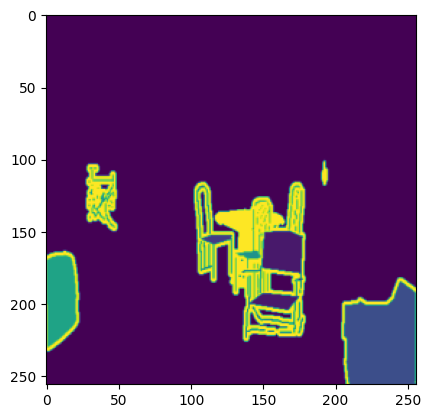

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


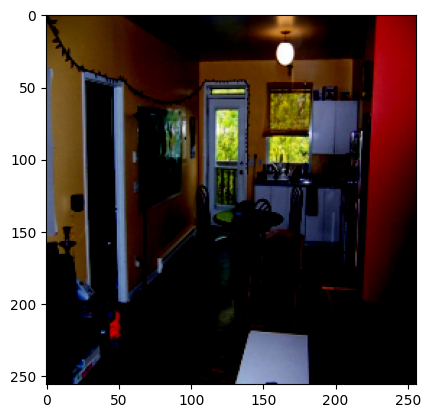

112.43699276447296
Epoch 3 | Loss: 0.6144 | Accuracy: 68.304444930825980%


In [ ]:
epoch_num = 40

for epoch in range(epoch_num):

    model.train()
    running_loss = 0.0
    num_correct = 0
    total_pixels = 0
    i = 0
    
    

    for (image, mask) in (image_loader):
          
        image = image.cuda()
        annotation = mask.cuda()
        #print(F"image: {image.shape}")
        #print(F"annotation: {annotation.shape}")

        optimizer.zero_grad()

        output = model(image)
        #print(F"output: {output.shape}")
        loss = criterion(output, annotation)
        loss.backward()
        
        running_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(running_loss)
        i += 1

        # Compute accuracy
        _,predicted = torch.max(output, 1)
        probability = torch.sigmoid(output)
        predicted = (probability > 0.5).float()
        num_correct += (predicted == annotation).sum().item()
        total_pixels += torch.numel(annotation)
        del output, loss
        torch.cuda.empty_cache()
        
        if(i == 5 and epoch == 2):
            image_np = annotation[0].cpu()
            image_np = image_np.permute(1,2,0).numpy()
            plt.imshow(image_np)
            plt.show()
            image_real = image[0].cpu()
            image_real = image_real.permute(1,2,0).numpy()
            plt.imshow(image_real)
            plt.show()
            

    accuracy = 100 * (num_correct / total_pixels)
    epoch_loss = running_loss / len(image_loader)
    print(running_loss)
    print(f'Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {accuracy:.15f}%')


In [ ]:
if __name__ == "__main__":
    model = UNet(input_channels=3, num_classes=2)

    x = torch.randn(1, 3, 512, 512)

    # Forward pass
    output = model(x)
    print(output.shape);